In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
%cd drive/MyDrive/TechLabsGroupProject

[Errno 2] No such file or directory: 'drive/MyDrive/TechLabsGroupProject'
/content/drive/MyDrive/TechLabsGroupProject


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re

As GitHub limited the number of times it could be scraped (it became unrelable at ~2000 and failed before 3000) data was fetched in 5 installations resulting in 5 csv tables that must be combined.

In [85]:
df_1 = pd.read_csv('gitHubScrapResults.csv')
df_2 = pd.read_csv('gitHubScrapResults2.csv')
df_3 = pd.read_csv('gitHubScrapResults3.csv')
df_4 = pd.read_csv('gitHubScrapResults4.csv')
df_5 = pd.read_csv('gitHubScrapResults5.csv')

Combine the 5 dataframes into one and drop any duplicate entries (check on btoh data and language to ensure and entry for the same date but different language is not accidentally dropped).

In [86]:
df = pd.concat([df_1,df_2, df_3, df_4, df_5]).drop_duplicates(subset=['date', 'language']).reset_index(drop=True)

Check the number of entries to be worked with. It is still not a large amount of data but better than the < 1000 that was obtained with the GitHub API

In [87]:
df.shape

(8454, 3)

In [88]:
df.head()

,date,language,stars
0,2022-01-11T20:16:31Z,javascript,118k
1,2022-01-10T19:44:00Z,javascript,16.5k
2,2022-01-15T21:26:25Z,javascript,132k
3,2021-11-08T07:29:49Z,javascript,2.6k
4,2020-10-02T14:46:31Z,javascript,1.5k


In [89]:
df.dtypes

date        object
language    object
stars       object
dtype: object

Examining the data, it would be better to have a column for the year as entries will be grouped on language and year. To do this the data type of the date column must be changed from object to date, then just the year selected. This will be stored in a new column called 'year'. The date column will be left unchanged (except to change from object to datetime)

In [90]:
df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')
df['year_month'] = pd.to_datetime(df['date']).dt.strftime('%Y-%B')
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,language,stars,year,year_month
0,2022-01-11 20:16:31+00:00,javascript,118k,2022,2022-January
1,2022-01-10 19:44:00+00:00,javascript,16.5k,2022,2022-January
2,2022-01-15 21:26:25+00:00,javascript,132k,2022,2022-January
3,2021-11-08 07:29:49+00:00,javascript,2.6k,2021,2021-November
4,2020-10-02 14:46:31+00:00,javascript,1.5k,2020,2020-October


The type of the stars column must also be changed to a number type. Since some of the counts use the letter 'k' to denote it is a number in the thousands this must be taken into account before converting to number type. 

In [91]:
def convertToNumber(x):
  value = str(x).strip()
  contents = re.split('(^\d+\.?\d*)', value)
  results = list(filter(None, contents))
  if len(results) == 1:
    return float(results[0])
  elif results[1] == 'k':
    return float(results[0]) * 1000

df['stars'] = df['stars'].apply(convertToNumber)

df.dtypes

date          datetime64[ns, UTC]
language                   object
stars                     float64
year                       object
year_month                 object
dtype: object

Check that there are sufficient entries for each language for each year to extract meaningful conclusions.

In [92]:
df.groupby(['language', 'year']).size().to_frame()

0
language   year     
c          2009    4
           2010    4
           2011    8
           2012   20
           2013   27
...              ...
typescript 2018   43
           2019   60
           2020   70
           2021  345
           2022  217

[121 rows x 1 columns]

This shows that there are years in the data set that will not be included in this analysis. Remove years before 2017 and after 2021.

In [93]:
df['date'] = pd.to_datetime(df['date'])
filt = (df['date'].dt.year >= 2017) & (df['date'].dt.year <= 2021)
df_years = df.loc[filt]

df_years.shape

(5887, 5)

This is the total number of entries for the years selected. It is not as large a number of data entries as would be wanted. But to gain experience with data science analysis this will have to suffice. 

In [94]:
df_years.head(5)

,date,language,stars,year,year_month
3,2021-11-08 07:29:49+00:00,javascript,2600.0,2021,2021-November
4,2020-10-02 14:46:31+00:00,javascript,1500.0,2020,2020-October
7,2021-10-31 07:40:52+00:00,javascript,62000.0,2021,2021-October
9,2021-07-08 13:39:40+00:00,javascript,1400.0,2021,2021-July
12,2019-01-15 09:44:22+00:00,javascript,625.0,2019,2019-January


The indices have been thrown off by dropping some entries. Reset the index.

In [95]:
df_years.reset_index(drop=True, inplace=True)
df_years.head(5)

,date,language,stars,year,year_month
0,2021-11-08 07:29:49+00:00,javascript,2600.0,2021,2021-November
1,2020-10-02 14:46:31+00:00,javascript,1500.0,2020,2020-October
2,2021-10-31 07:40:52+00:00,javascript,62000.0,2021,2021-October
3,2021-07-08 13:39:40+00:00,javascript,1400.0,2021,2021-July
4,2019-01-15 09:44:22+00:00,javascript,625.0,2019,2019-January


Next must verify that each of the languages has sufficient entries for each of the year. Group by language and year then count the number of entries that exist for this dual grouping. Then reset the index so the year and language can be used in a seaborn plot.

In [96]:
df_language_groups_size = df_years.groupby(['language', 'year']).size().to_frame()
df_language_groups_size.rename(columns={0: 'repo_count'}, inplace=True)
df_language_groups_size.reset_index(inplace=True)
df_language_groups_size

,language,year,repo_count
0,c,2017,85
1,c,2018,78
2,c,2019,90
3,c,2020,133
4,c,2021,106
5,c#,2017,102
6,c#,2018,134
7,c#,2019,99
8,c#,2020,167
9,c#,2021,147


Unlike the data from the GitHub API, here there are sufficent entries for each language in each year. A visual representation of the data demonstrates that each language has entries for each of the required years.

Text(0.5, 1.0, 'Number of repos per language each year')

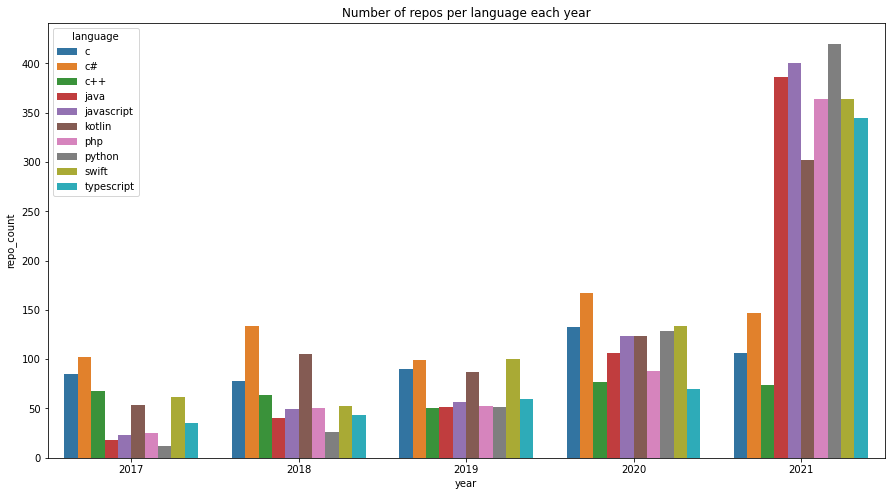

In [97]:
plt.figure(figsize = (15,8))
sns.barplot(x = "year", y = "repo_count", hue = "language", data = df_language_groups_size).set_title('Number of repos per language each year')

It is important not to take too much away from the above graph. At first glance it looks like the number of repos in each year could give information about the popularity. However the data was a random sampling. There is no way to no if any preceived trends are due to more repositories actually existing or just an artifact of the sampling process. 

Instead, for each year the breakdown of stars (aka followed) repositories will be examine. The reasoning for this is as follows. Repositories that are older (e.g. 2017 versus 2021) have more time to be followed. This could create a false impression of popularity. A 2017 repository in C# with thousands of followers may look very popular compared to a 2021 python repository with only a few hundred. But this could be due to the amount of time the respective repositories have been available for followign and use. The c# repository with thousands of followers could be insignificant when compared with all the stars for all the repositories in 2017. Carrying out the comparison within the year reduces the possible impact of time.

First get the total number of stars for each language in each year.

In [98]:
df_years_stars_sum = df_years.groupby(['language', 'year']).agg({'stars': 'sum'})
df_years_stars_sum

stars
language   year           
c          2017     6646.0
           2018     5719.0
           2019     6881.0
           2020     9108.0
           2021    12548.0
c#         2017     8308.0
           2018    10611.0
           2019     7349.0
           2020    22090.0
           2021    14136.0
c++        2017     5182.0
           2018     4059.0
           2019     2924.0
           2020     3922.0
           2021     5572.0
java       2017     8240.0
           2018    29135.0
           2019    57709.0
           2020   139721.0
           2021   781073.0
javascript 2017    17880.0
           2018    95761.0
           2019    61600.0
           2020   220292.0
           2021  1299172.0
kotlin     2017    15178.0
           2018    36285.0
           2019    39782.0
           2020    52678.0
           2021   202958.0
php        2017     9251.0
           2018    34739.0
           2019    55363.0
           2020    66759.0
           2021   457328.0
python     2017     6954.0
           2018     8391.0
           2019    44222.0
           2020   146601.0
           2021   868409.0
swift      2017    50130.0
           2018    34910.0
           2019    73480.0
           2020   151618.0
           2021   724125.0
typescript 2017     8172.0
           2018     8815.0
           2019    34107.0
           2020    47350.0
           2021   215127.0

Then for each year get the total number of stars for all languages.

In [99]:
df_star_sum_for_year = df_years.groupby(['year']).agg({'stars': 'sum'})
df_star_sum_for_year

,stars
year,
2017,135941.0
2018,268425.0
2019,383417.0
2020,860139.0
2021,4580448.0


Now find the percentage each language has of the total number of stars for each year.

In [100]:
df_language_popularity = df_years_stars_sum.div(df_star_sum_for_year, level='year') * 100
df_language_popularity.head(7)

stars
language year          
c        2017  4.888886
         2018  2.130577
         2019  1.794652
         2020  1.058899
         2021  0.273947
c#       2017  6.111475
         2018  3.953060

The column labeled stars is not a measure of popularity and must be renamed as such. Also, reset the index for language and year to make the result easily plotable. 

In [101]:
df_language_popularity.rename(columns={'stars': 'popularity_ranking'}, inplace=True)
df_language_popularity.reset_index(inplace=True)
df_language_popularity.head(7)

,language,year,popularity_ranking
0,c,2017,4.888886
1,c,2018,2.130577
2,c,2019,1.794652
3,c,2020,1.058899
4,c,2021,0.273947
5,c#,2017,6.111475
6,c#,2018,3.953060


Now lets look at the same bar chart as shown above with the number of repositories per language per year. But with the newly processed data for each language's popularity. 

Text(0.5, 1.0, 'Popularity ranking for a language per year')

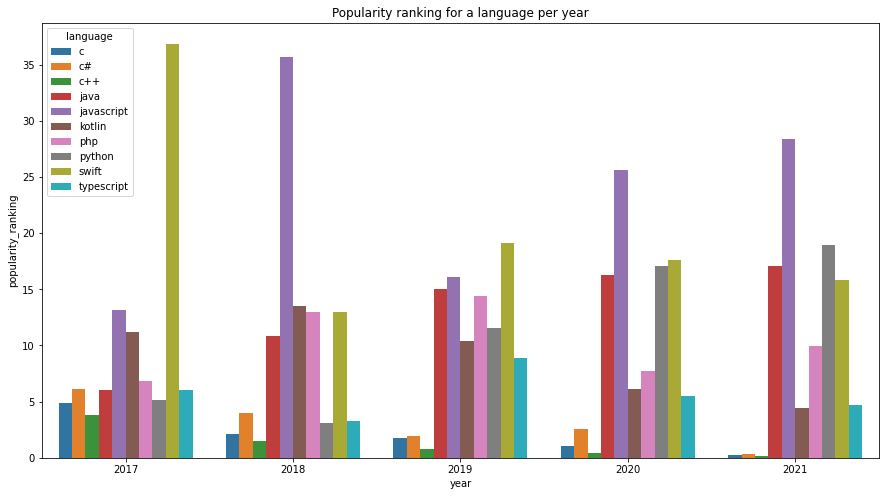

In [102]:
plt.figure(figsize = (15,8))
sns.barplot(x = "year", y = "popularity_ranking", hue = "language", data = df_language_popularity).set_title('Popularity ranking for a language per year')

Look at the two side by side to better compare the different results.

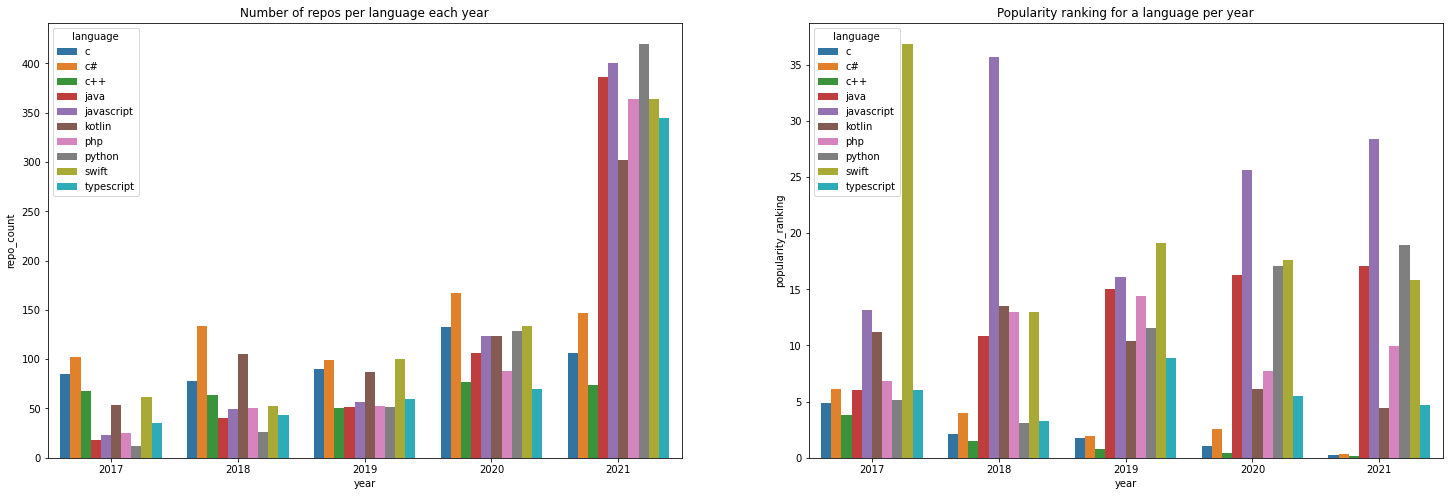

In [103]:
plt.figure(figsize = (25,8))
plt.subplot(1,2,1)
sns.barplot(x = "year", y = "repo_count", hue = "language", data = df_language_groups_size).set_title('Number of repos per language each year')
plt.subplot(1,2,2)
sns.barplot(x = "year", y = "popularity_ranking", hue = "language", data = df_language_popularity).set_title('Popularity ranking for a language per year')

plt.show()

It is visible here how the number of repositories did not actually provide a good measure of popularity. A language like c# appears to have a consistent and relatively high popularity based on repo count (highest number for 2017-2020). But looking at the percentage of stars (followers) the c# libraries have, it is clearly visible that it is not a major player - infact it is middling at best and decreases over the 5 year timeframe being examined. 

Swift seems to have had a large number of followers in 2017 but overall JavaScript seems to be the most popular, with Swift, Java, and Python vying for the following top spots.

These results are best observed on a line plot. This gives a better idea of the changes over time.

Text(0.5, 1.0, 'Language popularity over the year 2017-2020')

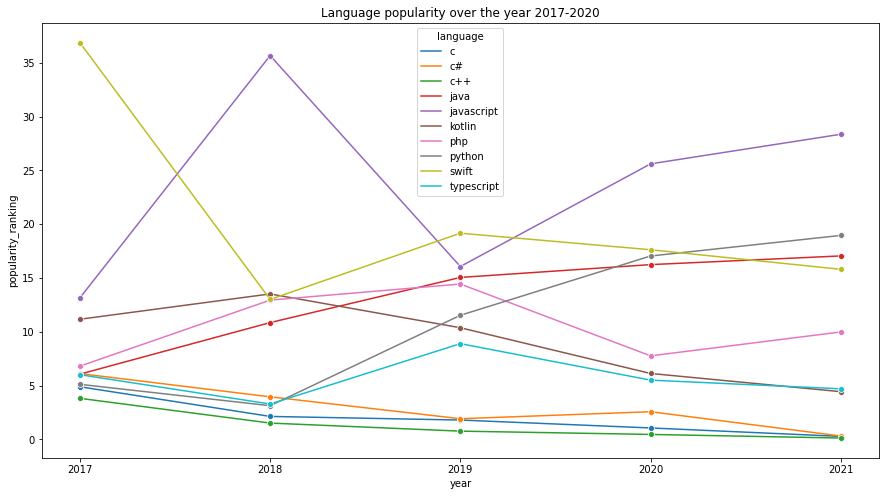

In [104]:
plt.figure(figsize = (15,8))
sns.lineplot(x='year', y='popularity_ranking', hue='language', data=df_language_popularity, marker="o").set_title('Language popularity over the year 2017-2020')

Set up the dataframe to be used on the website and export to csv.

In [105]:
columns_titles = ["year","language","popularity_ranking"]
df_language_popularity=df_language_popularity.reindex(columns=columns_titles)
df_language_popularity.head(7)

,year,language,popularity_ranking
0,2017,c,4.888886
1,2018,c,2.130577
2,2019,c,1.794652
3,2020,c,1.058899
4,2021,c,0.273947
5,2017,c#,6.111475
6,2018,c#,3.953060


This requires creating a new dataframe.

In [106]:
newColumns = ['year', 'javascript', 'typescript', 'python', 'c#', 'c++', 'php', 'swift', 'c', 'kotlin', 'java']
years = ['2017', '2018', '2019', '2020', '2021', '2022']

data = [['2017', None, None, None, None, None, None, None, None, None, None],
        ['2018', None, None, None, None, None, None, None, None, None, None], 
        ['2019', None, None, None, None, None, None, None, None, None, None], 
        ['2020', None, None, None, None, None, None, None, None, None, None],
        ['2021', None, None, None, None, None, None, None, None, None, None]]

df_website_data = pd.DataFrame(data, columns=newColumns)
df_website_data.set_index('year', inplace=True)

for index, row in df_language_popularity.iterrows():
    year = row['year']
    language = row['language']
    popularity_ranking = row['popularity_ranking']
    df_website_data.loc[year, language] = popularity_ranking

df_website_data.reset_index(level=0, inplace=True)
df_website_data

,year,javascript,typescript,python,c#,c++,php,swift,c,kotlin,java
0,2017,13.1528,6.01143,5.11545,6.11147,3.81195,6.80516,36.8763,4.88889,11.1651,6.06145
1,2018,35.6751,3.28397,3.12601,3.95306,1.51215,12.9418,13.0055,2.13058,13.5177,10.8541
2,2019,16.0661,8.89554,11.5337,1.91671,0.762616,14.4394,19.1645,1.79465,10.3756,15.0512
3,2020,25.6112,5.50492,17.0439,2.56819,0.455973,7.76142,17.6272,1.0589,6.12436,16.244
4,2021,28.3634,4.69664,18.959,0.308616,0.121647,9.98435,15.809,0.273947,4.43096,17.0523


In [108]:
df_website_data.to_csv('/github_language_popularity.csv')